<a href="https://colab.research.google.com/github/wangjuan001/planets/blob/master/01_matmul.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
import operator

def test(a, b, cmp, cname=None):
    if cname is None: cname=cmp.__name__
    assert cmp(a,b), f"{cname}:\n{a}\n{b}"
    
def test_eq(a,b): test(a,b,operator.eq, "==")

In [0]:
TEST = 'test'

In [0]:
test_eq(TEST, 'test')

##Get data

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor


In [0]:
MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'

In [11]:
path = datasets.download_data(MNIST_URL, ext='.gz'); path

PosixPath('/root/.fastai/data/mnist.pkl.gz')

In [0]:
with gzip.open(path,'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f,encoding='latin-1')

In [33]:
print(x_train.shape, y_train.shape, x_valid.shape, y_valid.shape)
print(x_train.max(), y_train.max(), x_valid.max())

(50000, 784) (50000,) (10000, 784) (10000,)
0.99609375 9 0.99609375


In [0]:
x_train, y_train, x_valid, y_valid = map(tensor, (x_train, y_train, x_valid, y_valid))

In [36]:
n,c = x_train.shape
x_train, x_train.shape, y_train, y_train.shape, y_train.min(), y_train.max()

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([50000, 784]),
 tensor([5, 0, 4,  ..., 8, 4, 8]),
 torch.Size([50000]),
 tensor(0),
 tensor(9))

In [0]:
assert n == y_train.shape[0] == 50000
test_eq(c,28*28)
test_eq(y_train.min(),0)
test_eq(y_train.max(),9)

In [0]:
mpl.rcParams['image.cmap'] = 'gray'

In [50]:
img = x_train[0]
img.view(28*28).type()

'torch.FloatTensor'

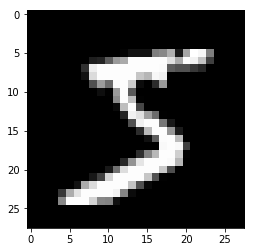

In [52]:
plt.imshow(img.view((28,28)))

##Initial python model


In [0]:
weights = torch.randn(784,10)

In [0]:
bias = torch.zeros(10)

###Matrix multiplication

In [0]:
def matmul(a,b):
    ar, ac = a.shape
    br, bc = b.shape
    assert ac == br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            for k in range(ac):
                c[i, j] += a[i,k] * b[k,j]
    return c

In [0]:
m1 = x_valid[:5]
m2 = weights

In [57]:
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [58]:
%time t1 = matmul(m1, m2)

CPU times: user 860 ms, sys: 0 ns, total: 860 ms
Wall time: 859 ms


In [59]:
t1.shape

torch.Size([5, 10])

###elementwise matmul

In [0]:
def matmul(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    assert ac == br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            c[i, j] = (a[i,:]* b[:,j]).sum()
    
    return c
            

In [67]:
%timeit  _=matmul(m1,m2)


CPU times: user 2.03 ms, sys: 3 µs, total: 2.03 ms
Wall time: 2.28 ms


In [0]:
def near(a, b): return torch.allclose(a, b, rtol=1e-3, atol=1e-5)
def test_near(a, b): test(a, b, near)

In [0]:
test_near(t1, matmul(m1,m2))

In [62]:
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

###broadcasting

In [76]:
a = tensor([10., 6, -4])
b = tensor([2., 8, 7])
a, b

(tensor([10.,  6., -4.]), tensor([2., 8., 7.]))

In [77]:
a + b

tensor([12., 14.,  3.])

In [78]:
(a < b).float().mean()

tensor(0.6667)

In [79]:
m = tensor([[1., 2, 3], [4,5,6], [7,8,9]]); m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [80]:
c = tensor([10.,20,30]); c

tensor([10., 20., 30.])

In [81]:
m.shape, c.shape

(torch.Size([3, 3]), torch.Size([3]))

In [82]:
m + c

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [83]:
c + m

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [85]:
t = c.expand_as(m)
t

tensor([[10., 20., 30.],
        [10., 20., 30.],
        [10., 20., 30.]])

In [86]:
m + t

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [106]:
m.unsqueeze(-1) 

tensor([[[1.],
         [2.],
         [3.]],

        [[4.],
         [5.],
         [6.]],

        [[7.],
         [8.],
         [9.]]])

In [111]:
(m.unsqueeze(-1) *c)

tensor([[[ 10.,  20.,  30.],
         [ 20.,  40.,  60.],
         [ 30.,  60.,  90.]],

        [[ 40.,  80., 120.],
         [ 50., 100., 150.],
         [ 60., 120., 180.]],

        [[ 70., 140., 210.],
         [ 80., 160., 240.],
         [ 90., 180., 270.]]])

In [0]:
def matmul(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    assert ac == br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        c[i] = (a[i].unsqueeze(-1)*b).sum(dim=0)
        
    return c

In [112]:
%timeit -n 10 _=matmul(m1,m2)

10 loops, best of 3: 286 µs per loop


In [115]:
m1.shape;m2.shape

torch.Size([784, 10])

In [120]:
matmul(m1,m2)

tensor([[ 9.0977, -2.8541,  5.5533, -2.7965,  7.0985, -9.6482,  9.9947,  9.4419,
          0.0320,  4.8613],
        [ 3.9470, -3.6410,  1.0020,  3.6019, 12.4816, -0.9135, -7.3655, 16.5102,
         -5.6565,  5.4745],
        [11.3820, -4.5536, 15.0496, -8.4170, -8.2476, -1.9438,  2.4922,  1.0936,
         -3.6545, -6.1782],
        [ 1.2632,  1.4862,  7.9453, -2.3226,  3.3468, -7.3977, 23.4962,  1.4455,
         -7.3257,  3.1454],
        [-0.0684, -6.0129, -4.2032, -3.5388, -6.7795, -9.9139, -3.4071, 19.2665,
          1.4115, -8.8448]])

In [0]:
t2 = m1.matmul(m2)

In [0]:
m1@m2